In [11]:
import numpy as np
#!pip install tensorboardX
import torch
import torch.nn as nn
from vae import *
from DataL import * #OnlyImageDataset, get_imageset, get_imageclass
from simplediff import create_smaller_dataset
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torchvision import transforms
import pdb

In [54]:
def trainVAE(vae, optimizer, dataset, epochs, device, r_loss_factor=1.0):
    Tloss=[]
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        for i, (images, labels) in enumerate(dataset):
            images = images.to(device)

            optimizer.zero_grad()
            #pdb.set_trace()
            mu_v, log_var_v, images_out_v = vae(images)
            r_loss_v = nn.functional.binary_cross_entropy(images_out_v, images, reduction="none") #r_loss(images_out_v, images)
            r_loss_v=torch.sum(r_loss_v, dim=[1, 2, 3])
            kl_loss_v = kl_loss(mu_v, log_var_v)
            loss = torch.mean(kl_loss_v + r_loss_v * r_loss_factor)
            loss.backward()
            optimizer.step()

            epoch_loss+=loss.item()
        
        epoch_loss/=len(dataset)
        Tloss.append(epoch_loss)

    return Tloss, vae

print("done")

done


In [55]:
def imageclass(s , transform=None):
    base_dir = os.getcwd() #os.path.dirname(os.path.realpath(__file__))
    image_dir = os.path.join(base_dir, '256x256/photo/tx_000100000000/'+s)
    image_set = OnlyImageDataset(image_dir, transform=transform)

    return image_set

In [56]:
transform = transforms.ToTensor()
train_set = imageclass('cat', transform=transform)#get_dataset(args.dataset, args.data_dir, metadata)
#train_set = create_smaller_dataset(train_set)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#sampler = DistributedSampler(train_set) if ngpus > 1 else None
train_loader = DataLoader(
    train_set,
    batch_size=15,
    shuffle=None,
    num_workers=1,
    pin_memory=True,
)
image, label = next(iter(train_loader))
print(torch.min(image))
vae=VAE((3,256,256), 64*64).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr= 0.001)
#pdb.set_trace()
print("len", len(train_set))


tensor(0.)
len 100


In [57]:
Tloss, vae = trainVAE(vae, optimizer, train_loader, 600, device)

100%|████████████████████████████████████████████████████████████| 600/600 [06:23<00:00,  1.56it/s]


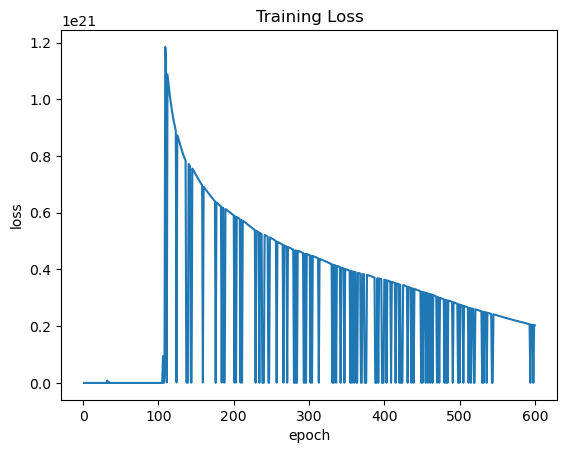

torch.Size([1, 3, 256, 256])


(-0.5, 255.5, 255.5, -0.5)

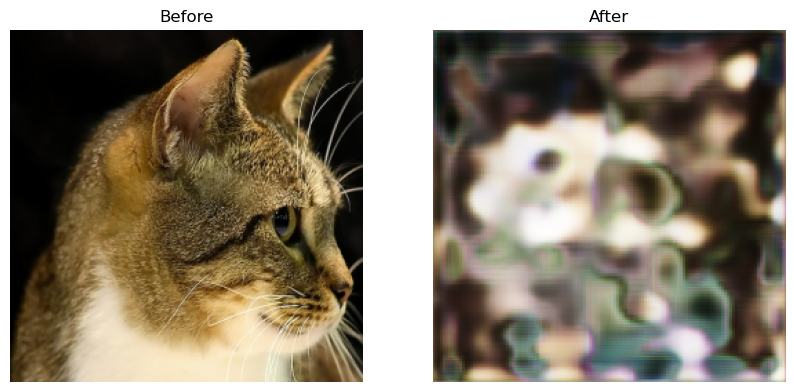

In [58]:
plt.plot(range(1,len(Tloss)+1), Tloss, label='Training loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training Loss")
plt.show()

i=random.randint(0,len(train_set)-1)
sk,im = train_set[i]


im = im.to(device)
im=im.unsqueeze(0)
print(im.shape)
_,_, out=vae(im)
out=out.squeeze(0)
out=out.cpu().detach().numpy()
out=np.transpose(out, (1, 2, 0))
im=im.squeeze(0)
im=im.cpu().detach().numpy()
im=np.transpose(im, (1, 2, 0))

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(im)
ax[0].set_title('Before')
ax[0].axis('off')

ax[1].imshow(out)
ax[1].set_title('After')
ax[1].axis('off')
